In [1]:
!pip install umap-learn pot 

In [2]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from metric.pca import *
from metric.fst import *
from metric.umap import *
from metric.precision_recall import *
from metric.correlation_score import *
from metric.aats import *
from metric.basic_sanity_check import *
from metric.allele_freq import *
from metric.geno_freq import *
from metric.LD import *
from metric.GWAS import *

2025-01-14 13:00:52.868652: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-14 13:00:52.868732: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-14 13:00:52.868792: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 13:00:52.881018: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-14 13:00:53.833985: W tensorflow/compiler/

In [4]:
seed_value = 42
# Set seeds for NumPy and PyTorch
np.random.seed(seed_value)
torch.manual_seed(seed_value)

# Import Datasets

## Cows

In [5]:
cows = pd.read_pickle("/home/jovyan/workspace/Dataset/Train_Val_Test_Sets_Data_Total/typages_SNP_train.pkl").iloc[:,1:]

In [6]:
# Calculate variance for each SNP (column)
variances = cows.var(axis=0)
# Filter SNPs that have variance above the threshold
high_variance_snps = variances[variances > 0.001].index
# Return filtered DataFrame
filtered_cows = cows[high_variance_snps]

In [7]:
filtered_cows_ch1 = filtered_cows.iloc[:, :3121]

In [8]:
cows_1 = filtered_cows.sample(n=10000, random_state=42)  
cows_2 = filtered_cows.sample(n=10000, random_state=22)  

In [9]:
cows_ch1_1 = filtered_cows_ch1.sample(n=10000, random_state=42)  
cows_ch1_2 = filtered_cows_ch1.sample(n=10000, random_state=22)  

In [10]:
pheno_cows = pd.read_pickle("/home/jovyan/workspace/Dataset/Train_Val_Test_Sets_Data_Total/data_YD_train_norm.pkl").iloc[:,2:]

In [11]:
pheno_cows_ch1_1 = pheno_cows.loc[cows_ch1_1.index]["YD_CAR4"].to_numpy()

In [12]:
pheno_cows_ch1_2 = pheno_cows.loc[cows_ch1_2.index]["YD_CAR4"].to_numpy()

In [13]:
pheno_cows_1 = pheno_cows.loc[cows_1.index]["YD_CAR4"].to_numpy()

In [14]:
pheno_cows_2 = pheno_cows.loc[cows_2.index]["YD_CAR4"].to_numpy()

## UKBioBank

In [4]:
# Loading Data
print("-> Loading data")
RG_train = pd.read_parquet("/home/jovyan/workspace/github_repo/DiscreteGenoGen/data/ch15/train.parquet")
RG_val = pd.read_parquet("/home/jovyan/workspace/github_repo/DiscreteGenoGen/data/ch15/val.parquet")

-> Loading data


In [5]:
sampled_RG_train = RG_train.sample(n=10000, random_state=42)  
sampled_RG_val = RG_val.sample(n=10000, random_state=42)  

In [7]:
nb_sequences = 10000
sequence_length = 6373

# Generate SNP sequences (0, 1, 2 with equal probability)
random = np.random.randint(0, 3, size=(nb_sequences, sequence_length))

# Display shape of the generated data
print(f"Generated SNP data shape: {random.shape}")

Generated SNP data shape: (10000, 6373)


In [9]:
def calculate_allele_frequencies(df):
    frequencies = {}
    for snp in df.columns:
        # Count the number of each genotype
        counts = df[snp].value_counts()
        num_homo_ref = counts.get(0, 0)  # Homozygous for reference allele
        num_hetero = counts.get(1, 0)    # Heterozygous
        num_homo_minor = counts.get(2, 0) # Homozygous for minor allele

        # Calculate the total number of minor alleles
        total_minor_alleles = num_hetero + 2 * num_homo_minor
        total_alleles = 2 * len(df[snp])  # Total number of alleles
        
        # Calculate frequency
        freq = total_minor_alleles / total_alleles
        frequencies[snp] = freq

    return frequencies

In [10]:
real_freq = calculate_allele_frequencies(sampled_RG_train)

In [11]:
def generate_genotype_dataframe(allele_freq_dict, n_individuals=10000):
    """
    Generate a genotype dataframe based on allele frequencies.
    
    Parameters:
        allele_freq_dict (dict): Dictionary where keys are SNP names and values are allele frequencies (p).
        n_individuals (int): Number of individuals (rows) to generate.
        
    Returns:
        pd.DataFrame: Genotype dataframe with individuals as rows and SNPs as columns.
    """
    snp_names = list(allele_freq_dict.keys())
    genotype_data = []
    
    for snp, freq in allele_freq_dict.items():
        # Compute genotype probabilities based on allele frequency
        p_0 = (1 - freq) ** 2  # Homozygous alternate
        p_1 = 2 * freq * (1 - freq)  # Heterozygous
        p_2 = freq ** 2  # Homozygous reference
        
        # Generate genotypes for n_individuals
        genotypes = np.random.choice(
            [0, 1, 2], size=n_individuals, p=[p_0, p_1, p_2]
        )
        genotype_data.append(genotypes)
    
    # Combine into a DataFrame
    genotype_df = pd.DataFrame(np.array(genotype_data).T, columns=snp_names)
    return genotype_df

In [12]:
# Generate genotype DataFrame based on allele frequency
freq = generate_genotype_dataframe(real_freq)

# Result on cows' chromosome 1

In [15]:
path_cows_ch1 = "metric_analysis_result/cows_ch1/"
# Create the directory if it doesn't exist
if not os.path.exists(path_cows_ch1):
    os.makedirs(path_cows_ch1)
    print(f"Directory created: {path_cows_ch1}")

## Redundance or Release

In [24]:
result = basic_sanity_check(cows_ch1_1, cows_ch1_2)
print(result)

{'redundant_rows': 0, 'shared_rows': 1097}


## Fixation Index

In [11]:
result = aggregated_fst(cows_ch1_1, cows_ch1_2)
print(result)

2.402511459232223e-05


## GWAS

In [16]:
gwas_cows_ch1_1 = gwas(cows_ch1_1, pheno_cows_ch1_1)

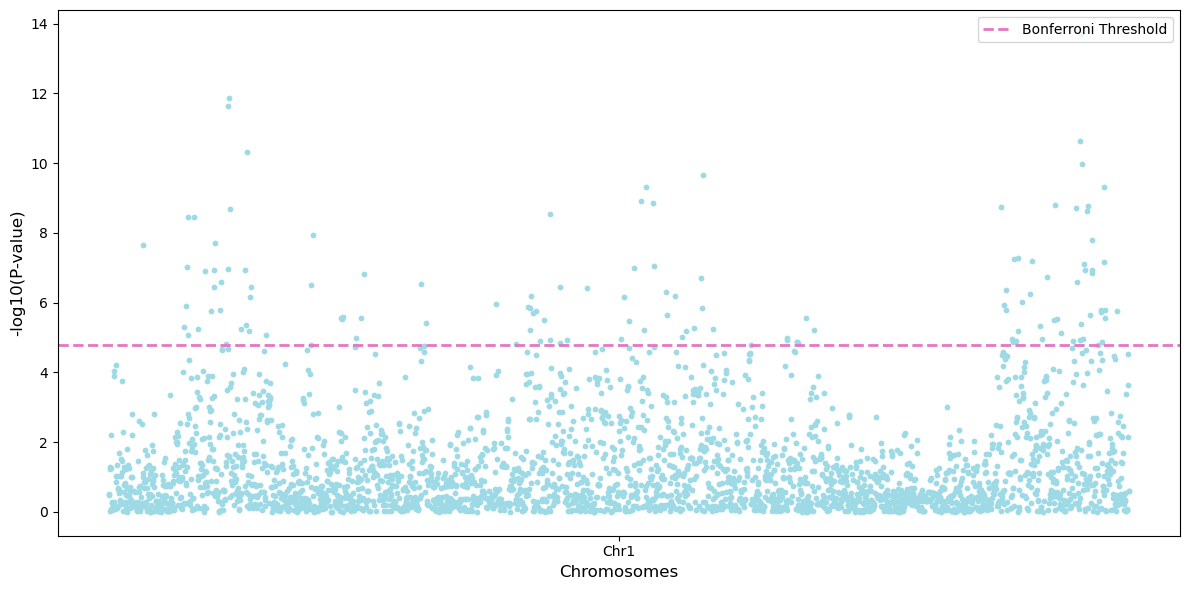

In [16]:
plot_gwas(cows_ch1_1, pheno_cows_ch1_1, {1: 3121}, path_cows_ch1+"gwas_1.png")

In [17]:
gwas_cows_ch1_2 = gwas(cows_ch1_2, pheno_cows_ch1_2)

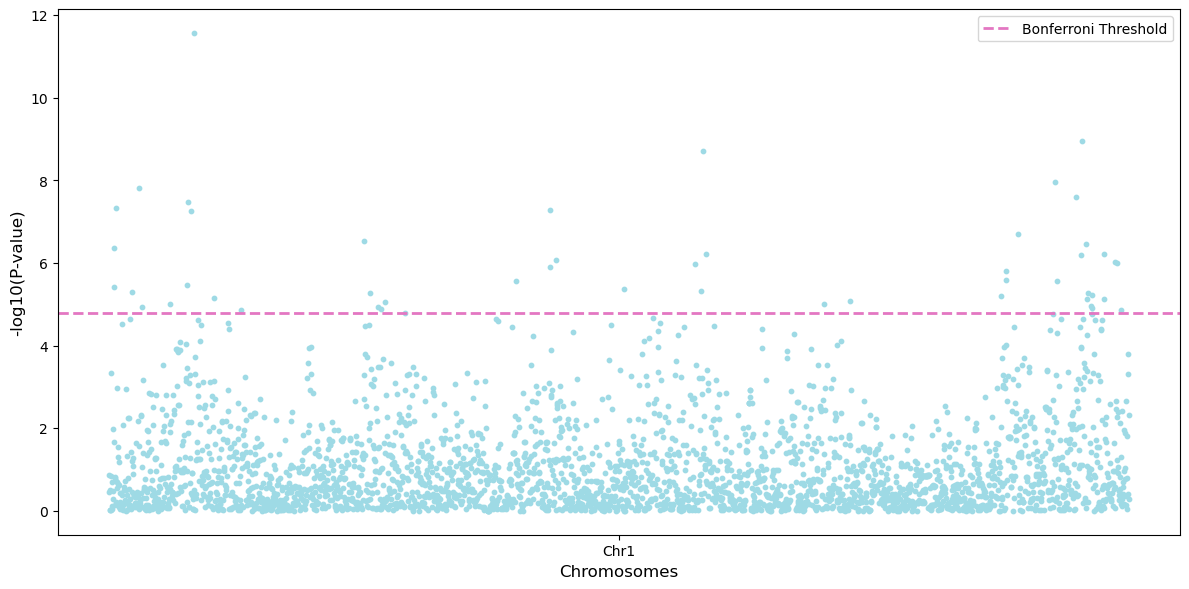

In [17]:
plot_gwas(cows_ch1_2, pheno_cows_ch1_2, {1: 3121}, path_cows_ch1+"gwas_2.png")

## PCA

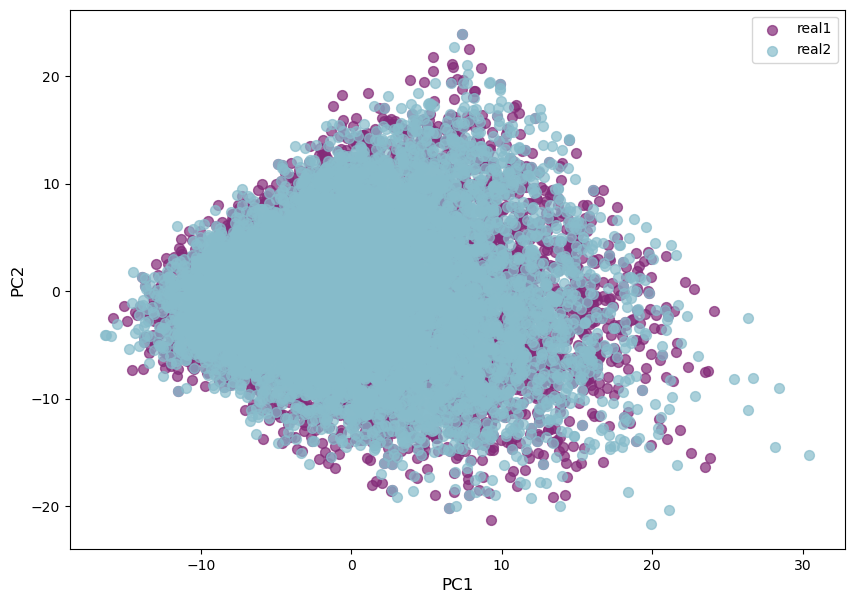

In [11]:
geno_PCA(cows_ch1_1,cows_ch1_2,"real1","real2",path_cows_ch1+"pca.png")

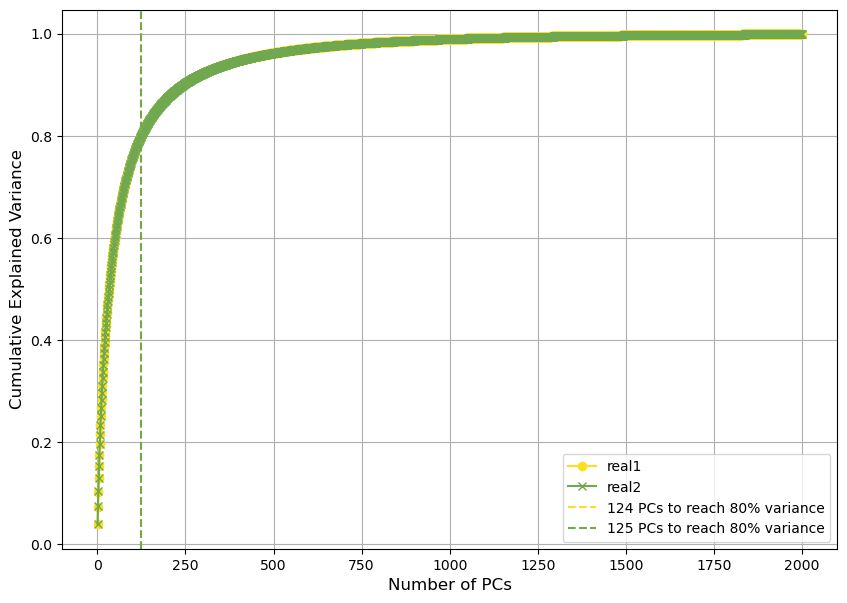

Multi-Dimensional Wasserstein Distance: 1394.1113692123847


/opt/conda/lib/python3.11/site-packages/ot/lp/__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


In [13]:
wd = cumu_var(cows_ch1_1,cows_ch1_2,"real1","real2",2000,path_cows_ch1+"cumu_var.png")
print(f"Multi-Dimensional Wasserstein Distance: {wd}")

## UMAP

/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


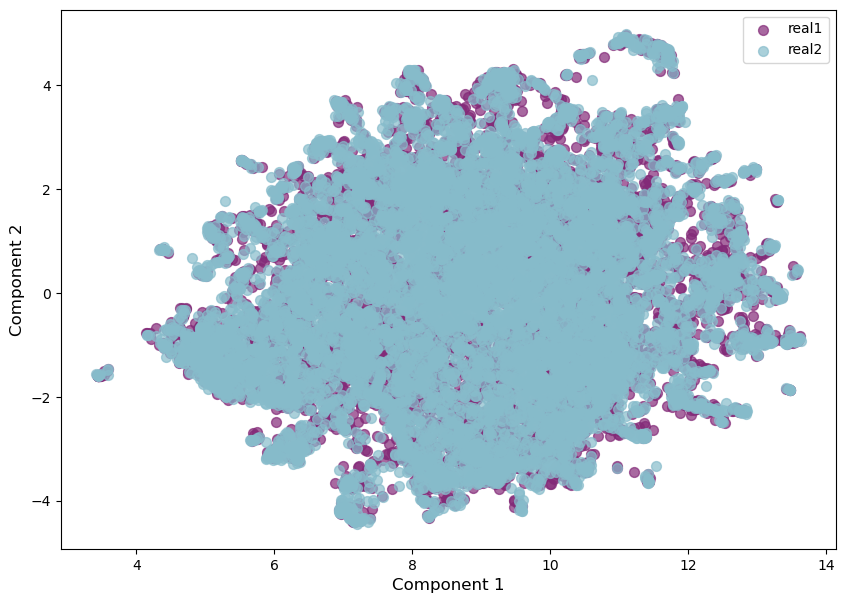

In [11]:
geno_UMAP(cows_ch1_1,cows_ch1_2,"real1","real2",path_cows_ch1+"umap.png")

## Precision and Recall

In [11]:
ks = [3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

### Using L2 distance

In [12]:
precision_cows_ch1_euc, recall_cows_ch1_euc = get_precision_recall(torch.tensor(cows_ch1_1.to_numpy()).to(dtype=torch.float32), torch.tensor(cows_ch1_2.to_numpy()).to(dtype=torch.float32), ks=ks, distance = "euclidean")

Evaluated k-NN precision and recall in: 9.28095s


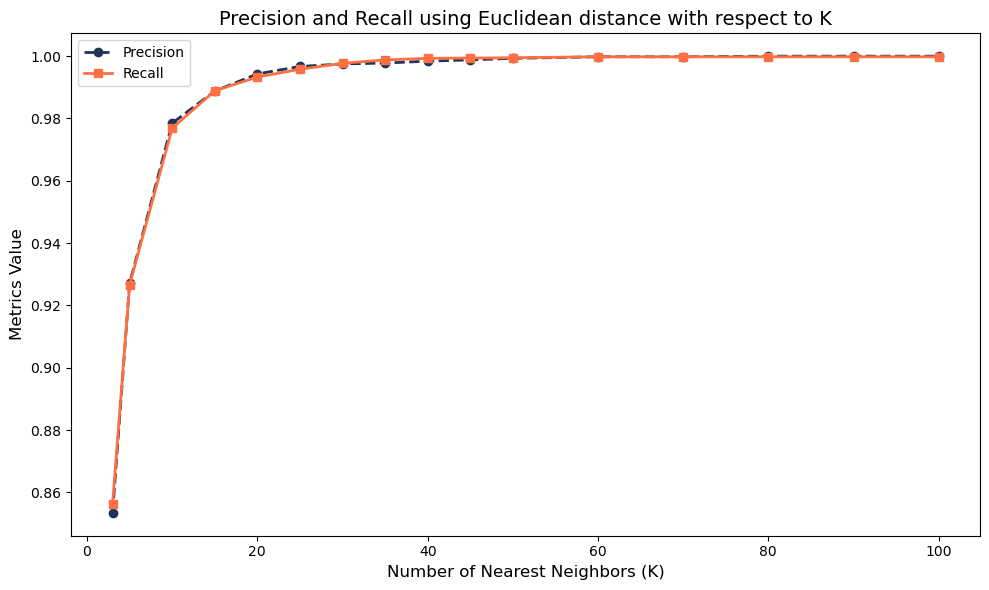

In [24]:
# Plot precision and recall on the same graph
plt.figure(figsize=(10, 6))
plt.plot(ks, precision_cows_ch1_euc, marker='o', label='Precision', color='#1D3557', linestyle='--', linewidth=2)
plt.plot(ks, recall_cows_ch1_euc, marker='s', label='Recall', color='#FF6F43', linestyle='-', linewidth=2)
plt.title("Precision and Recall using Euclidean distance with respect to K", fontsize=14)
plt.xlabel("Number of Nearest Neighbors (K)", fontsize=12)
plt.ylabel("Metrics Value", fontsize=12)
plt.legend(fontsize=10)
# Customize layout
plt.tight_layout()

# Save and show the plot
plt.savefig(path_cows_ch1+"precision_recall_euc.png", dpi=300)
plt.show()

### Using L1 distance

In [15]:
precision_cows_ch1_mht, recall_cows_ch1_mht = get_precision_recall(torch.tensor(cows_ch1_1.to_numpy()).to(dtype=torch.float32), torch.tensor(cows_ch1_2.to_numpy()).to(dtype=torch.float32), ks=ks, distance = "manhattan")

Evaluated k-NN precision and recall in: 25.8425s


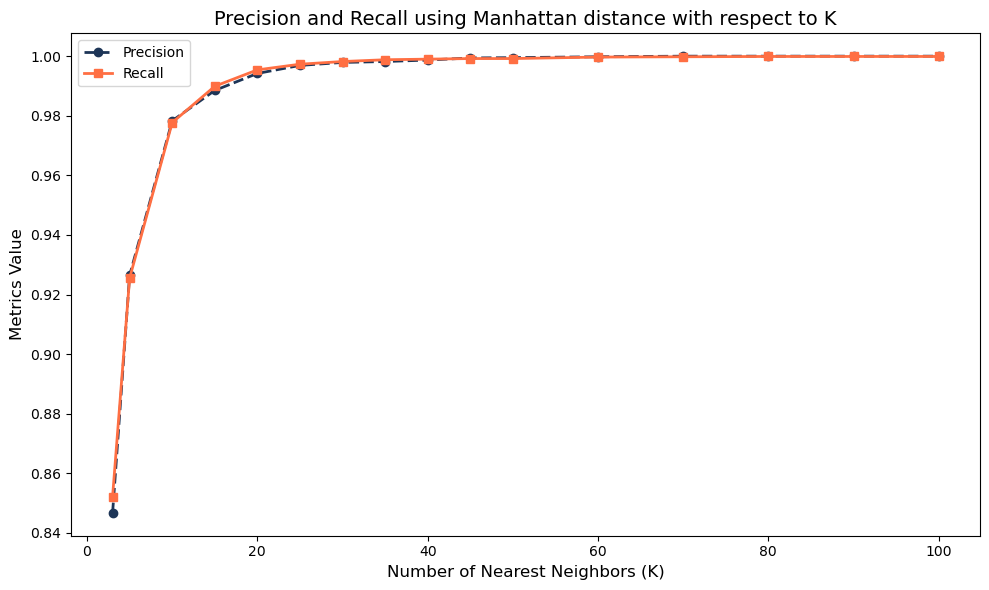

In [25]:
# Plot precision and recall on the same graph
plt.figure(figsize=(10, 6))
plt.plot(ks, precision_cows_ch1_mht, marker='o', label='Precision', color='#1D3557', linestyle='--', linewidth=2)
plt.plot(ks, recall_cows_ch1_mht, marker='s', label='Recall', color='#FF6F43', linestyle='-', linewidth=2)
plt.title("Precision and Recall using Manhattan distance with respect to K", fontsize=14)
plt.xlabel("Number of Nearest Neighbors (K)", fontsize=12)
plt.ylabel("Metrics Value", fontsize=12)
plt.legend(fontsize=10)
# Customize layout
plt.tight_layout()

# Save and show the plot
plt.savefig(path_cows_ch1+"precision_recall_mht.png", dpi=300)
plt.show()

## Correlation Score

In [37]:
corr_cows_ch1 = corr_score(cows_ch1_1, cows_ch1_2)
print("Correlation Score between two real datasets from cow's first chromosome: " + str(corr_cows_ch1))

Correlation Score between two real datasets from cow's first chromosome: 0.9891237622738124


## Allele Frequency

/home/jovyan/workspace/github_repo/DiscreteGenoGen/metric/allele_freq.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'r--', color="#FF6F43", label='y = x (Ideal Match)')


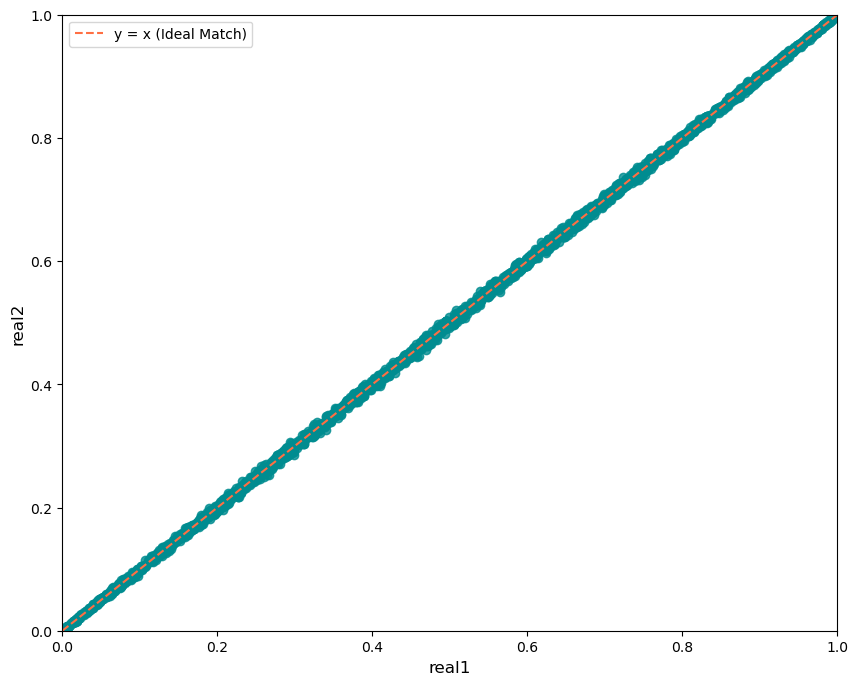

In [16]:
plot_allele_freq(cows_ch1_1, cows_ch1_2, "real1", "real2", path_cows_ch1+"allele_freq.png")

## Geno Frequency

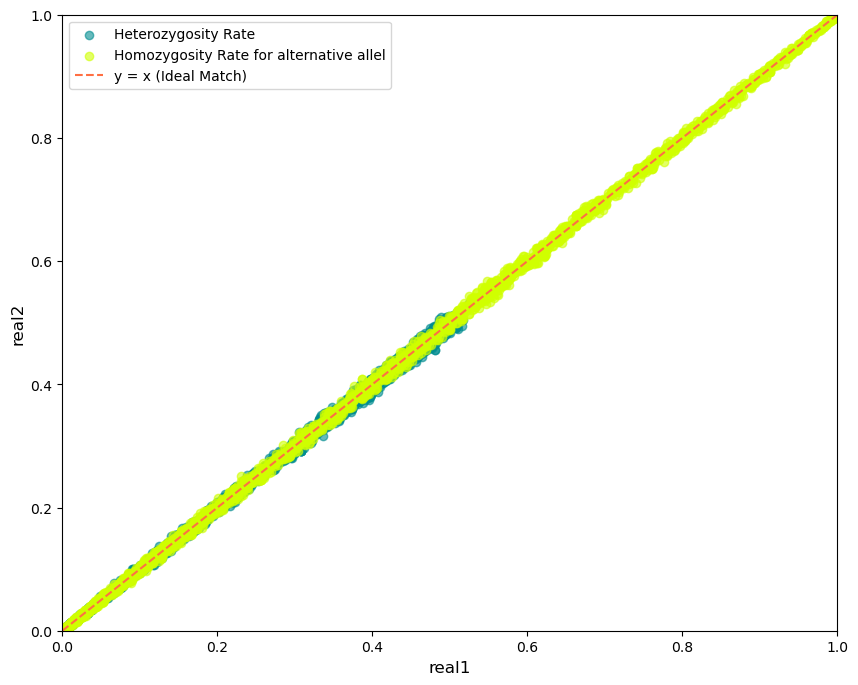

In [11]:
plot_geno_freq(cows_ch1_1, cows_ch1_2, "real1", "real2", path_cows_ch1+"geno_freq.png")

## AATS

### Using L2 distance

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


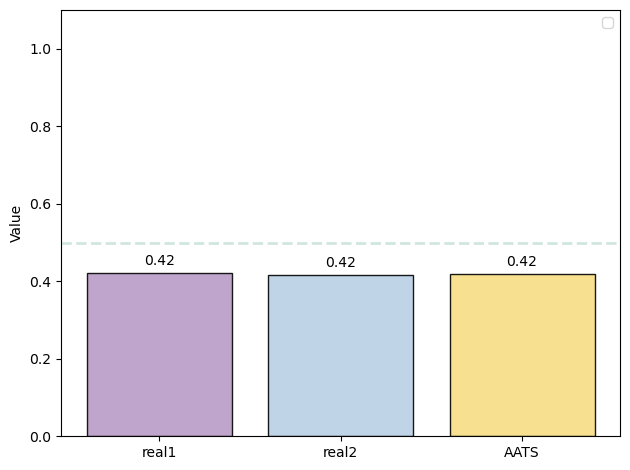

In [11]:
plot_aats(AATS(cows_ch1_1, cows_ch1_2, metric="euclidean"), "real1", "real2", path_cows_ch1+"AATS_euc.png")

### Using L1 distance

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


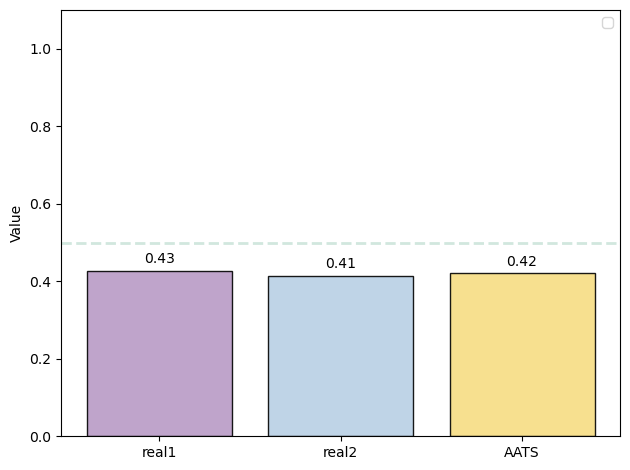

In [12]:
plot_aats(AATS(cows_ch1_1, cows_ch1_2, metric="manhattan"), "real1", "real2", path_cows_ch1+"AATS_mht.png")

## LD

### Pairwise LD

In [11]:
_, ld_cows_ch1_1,_ = LD(cows_ch1_1)

In [12]:
_, ld_cows_ch1_2,_ = LD(cows_ch1_2)

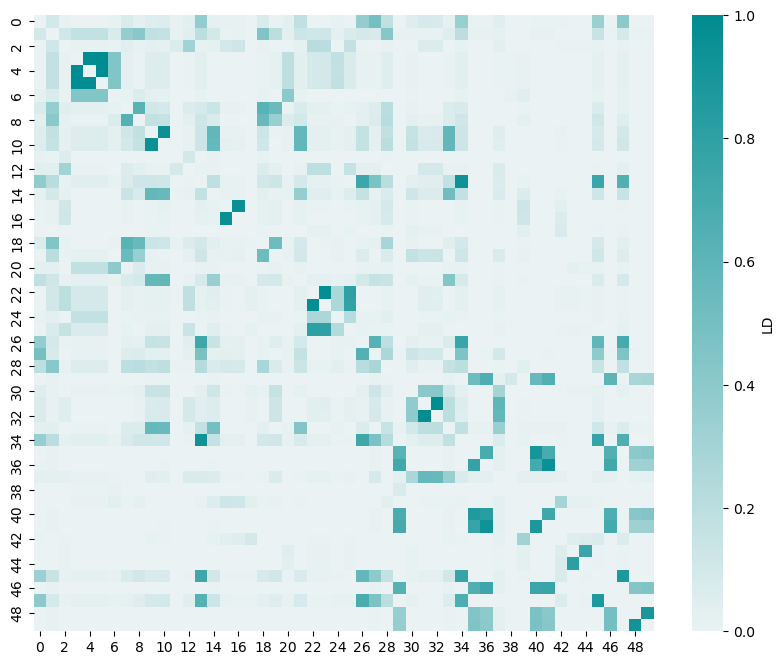

array([[0.0000000e+00, 9.9031687e-02, 8.2816193e-03, ..., 4.0167671e-01,
        5.6294381e-04, 6.9909554e-04],
       [1.0142495e-01, 0.0000000e+00, 1.1505091e-01, ..., 9.6541397e-02,
        6.1987583e-03, 6.7979833e-03],
       [3.3566994e-03, 1.1465176e-01, 0.0000000e+00, ..., 9.1370195e-03,
        1.0861412e-03, 9.7201864e-04],
       ...,
       [4.0007192e-01, 9.6146718e-02, 8.5480968e-03, ..., 0.0000000e+00,
        3.3050799e-04, 6.5285515e-04],
       [2.2527070e-03, 9.0524312e-03, 1.3297882e-04, ..., 7.6929171e-04,
        0.0000000e+00, 8.9677542e-01],
       [2.7668537e-03, 9.9182418e-03, 1.6940720e-04, ..., 1.0108355e-03,
        9.2782378e-01, 0.0000000e+00]], dtype=float32)

In [13]:
plot_LD(cows_ch1_1.iloc[:, :50], cows_ch1_2.iloc[:, :50], path_cows_ch1+"LD_50snps.png")

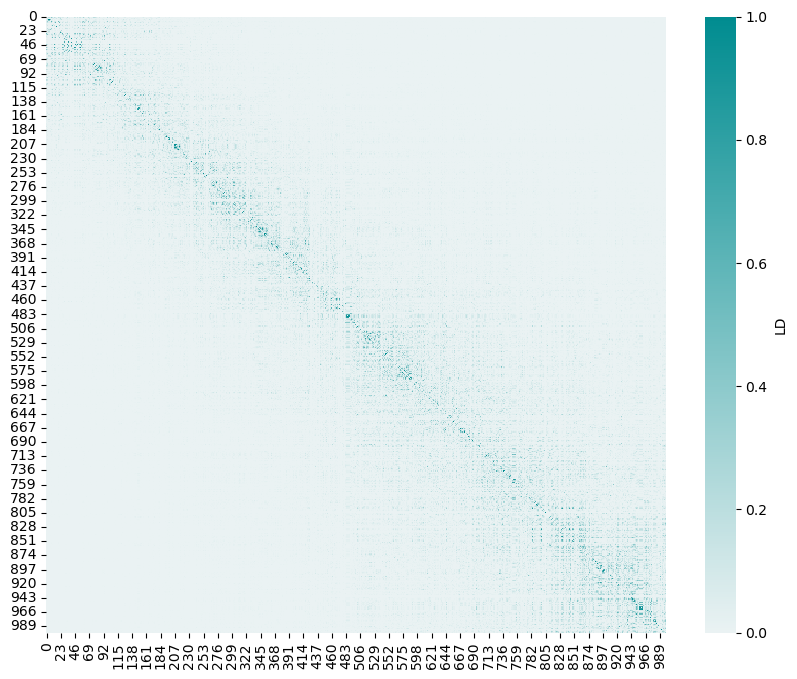

array([[0.00000000e+00, 9.90316868e-02, 8.28161929e-03, ...,
        1.05785846e-04, 1.42910099e-03, 6.43863459e-04],
       [1.01424947e-01, 0.00000000e+00, 1.15050912e-01, ...,
        6.79060584e-04, 1.87443584e-05, 1.69607898e-04],
       [3.35669937e-03, 1.14651762e-01, 0.00000000e+00, ...,
        2.25328899e-04, 4.69209102e-04, 2.58471875e-04],
       ...,
       [2.48547673e-04, 6.60817386e-05, 4.18081845e-06, ...,
        0.00000000e+00, 1.58583686e-01, 4.41372544e-02],
       [2.15857988e-03, 3.91633075e-04, 1.16204348e-04, ...,
        1.74332142e-01, 0.00000000e+00, 2.84149677e-01],
       [4.63380129e-04, 5.45454941e-06, 5.98509141e-05, ...,
        5.79730608e-02, 2.95211256e-01, 0.00000000e+00]], dtype=float32)

In [14]:
plot_LD(cows_ch1_1.iloc[:, :1000], cows_ch1_2.iloc[:, :1000], path_cows_ch1+"LD_1000snps.png")

### LD decay

In [11]:
# import the position information
ch1_snps = [col.replace("geno_SNP", "") for col in cows_ch1_1.columns]
ch1_snps = [int(ele) for ele in ch1_snps]
# SNP positions (in base pairs)
snp_info = pd.read_csv("/home/jovyan/data/position_variants_50Kp.txt", sep=" ", header=None)
snp_info.columns = ["Index", "Chromosome", "SNP_ID", "Position_MB"]
snp_info["Position_BP"] = (snp_info["Position_MB"] * 1e6).astype(int)
# Filter rows where SNP_ID is in the extracted list
ch1_snp_info = snp_info[snp_info["Index"].isin(ch1_snps)]

In [12]:
ch1_positions = ch1_snp_info["Position_BP"].to_numpy()

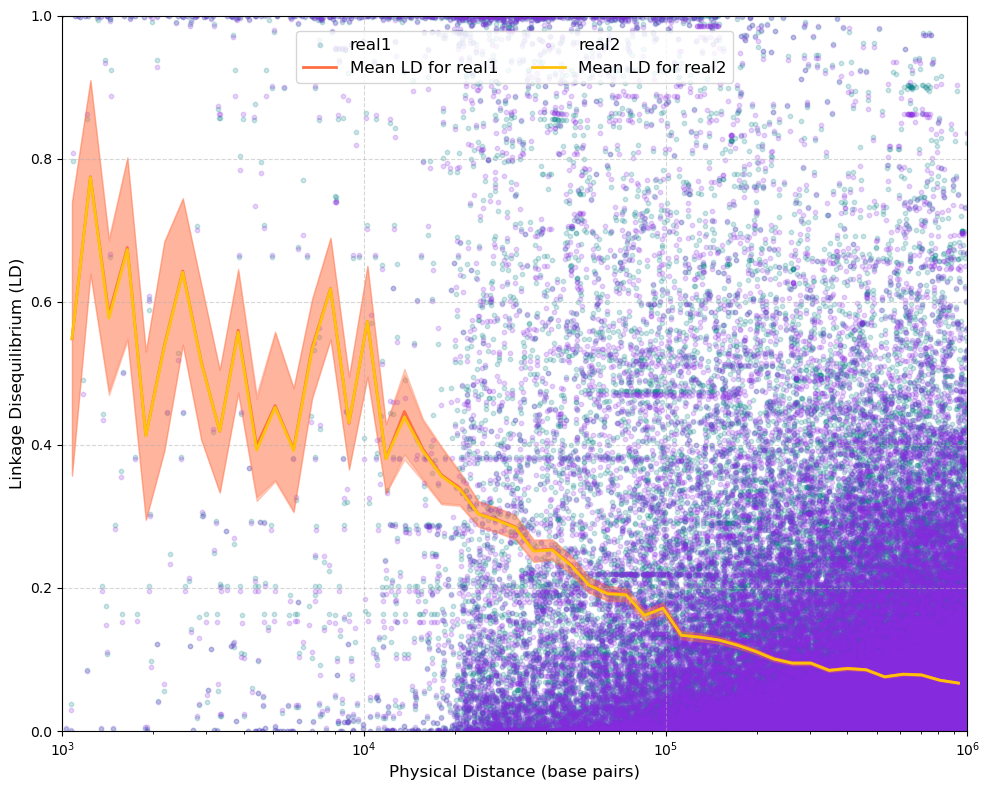

In [13]:
plot_LD_decay(cows_ch1_1, cows_ch1_2, ch1_positions, 10**6, 10**3, 10**6, "real1", "real2", path_cows_ch1+"LD_decay.png")

# Result on cows' all the chromosomes

In [16]:
path_cows_all = "metric_analysis_result/cows_all/"
# Create the directory if it doesn't exist
if not os.path.exists(path_cows_all):
    os.makedirs(path_cows_all)
    print(f"Directory created: {path_cows_all}")

## Fixation Index

In [15]:
result = aggregated_fst(cows_1, cows_2)
print(result)

2.245970776544949e-05


## GWAS

In [20]:
gwas_cows_1 = gwas(cows_1, pheno_cows_1)

In [21]:
gwas_cows_2 = gwas(cows_2, pheno_cows_2)

In [18]:
snp_info = pd.read_csv("/home/jovyan/data/position_variants_50Kp.txt", sep=" ", header=None)
snp_info.columns = ["Index", "Chromosome", "SNP_ID", "Position_MB"]
cows_ch_snps = [col.replace("geno_SNP", "") for col in cows_1.columns]
cows_ch_snps = [int(ele) for ele in cows_ch_snps]
filterd_snp_info = snp_info[snp_info['Index'].isin(cows_ch_snps)]
snp_count_per_chromosome = filterd_snp_info.groupby('Chromosome')['Index'].size().reset_index(name='SNP_Count')
cows_chr_dict = {}
accu_ind = 0
for i in range(snp_count_per_chromosome.shape[0]):
    accu_ind += snp_count_per_chromosome.loc[i]["SNP_Count"]
    cows_chr_dict[snp_count_per_chromosome.loc[i]["Chromosome"]] = accu_ind

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


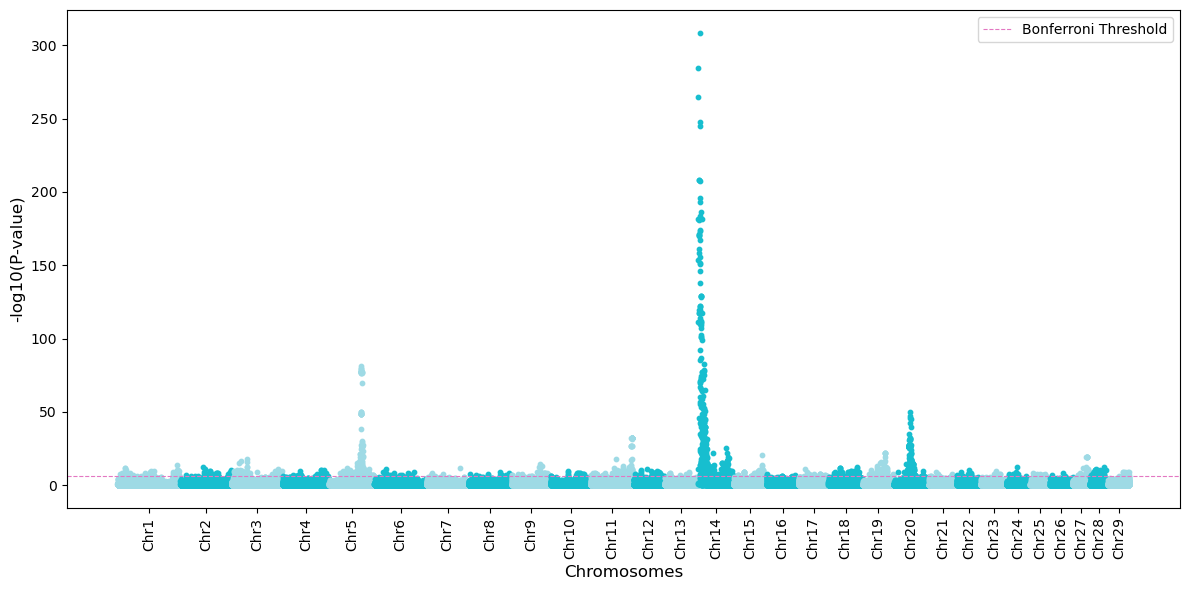

In [18]:
plot_gwas(cows_1, pheno_cows_1, cows_chr_dict, path_cows_all+"gwas_1.png")

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


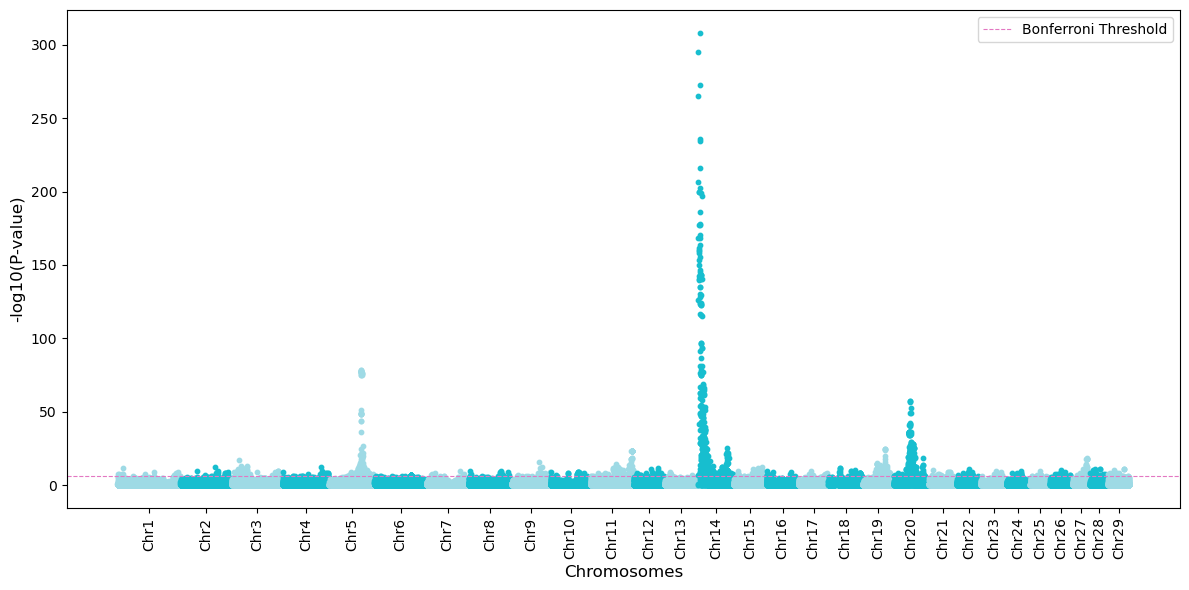

In [19]:
plot_gwas(cows_2, pheno_cows_2, cows_chr_dict, path_cows_all+"gwas_2.png")

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


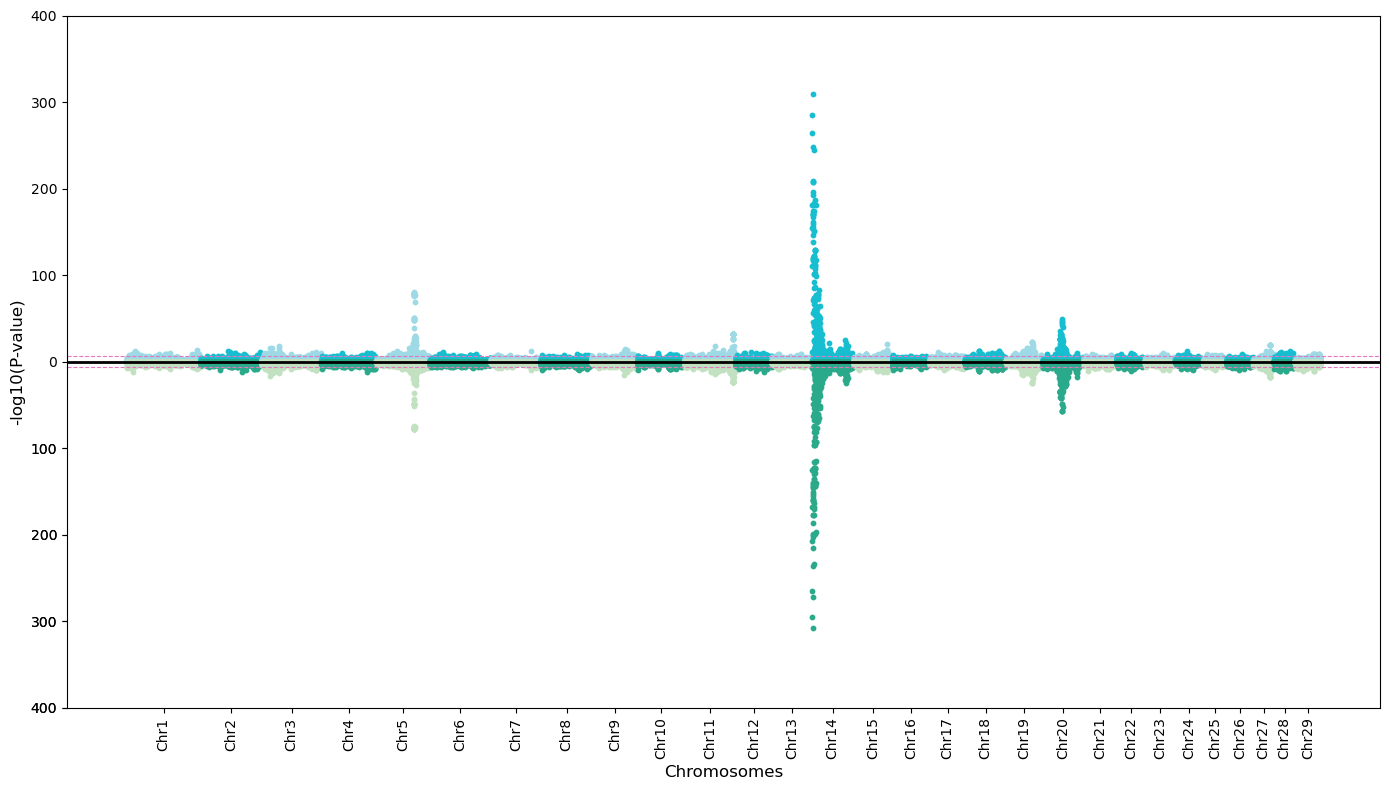

In [19]:
plot_compare_gwas(cows_1, pheno_cows_1, cows_2, pheno_cows_2, cows_chr_dict, "real1","real2", path_cows_all+"gwas_compare.png")

## PCA

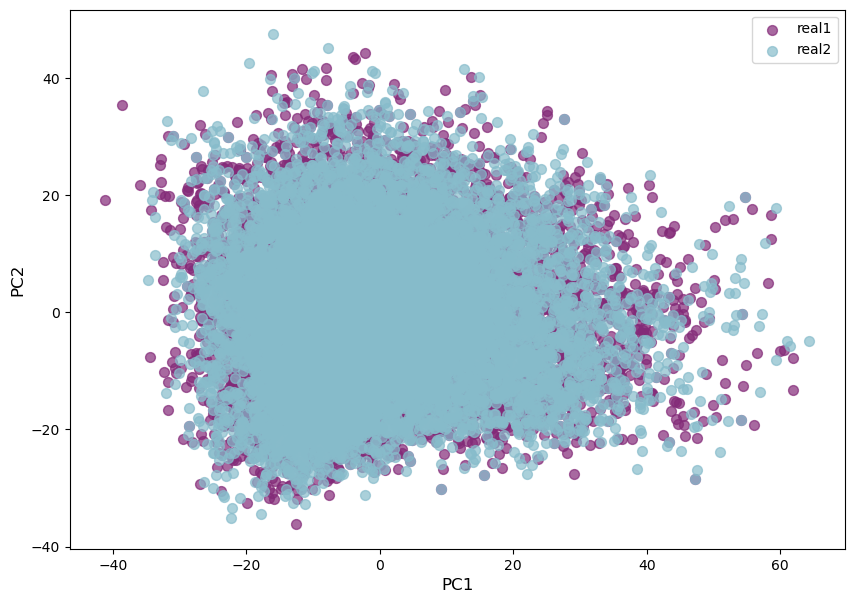

In [16]:
geno_PCA(cows_1,cows_2,"real1","real2",path_cows_all+"pca.png")

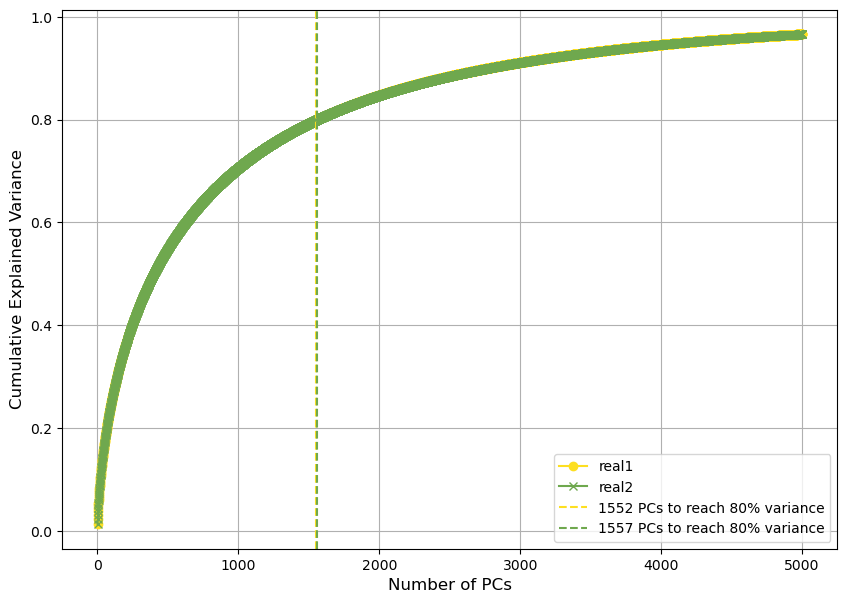

Multi-Dimensional Wasserstein Distance: 28338.256523586864


/opt/conda/lib/python3.11/site-packages/ot/lp/__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


In [17]:
wd = cumu_var(cows_1,cows_2,"real1","real2",5000,path_cows_all+"cumu_var.png")
print(f"Multi-Dimensional Wasserstein Distance: {wd}")

## UMAP

/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


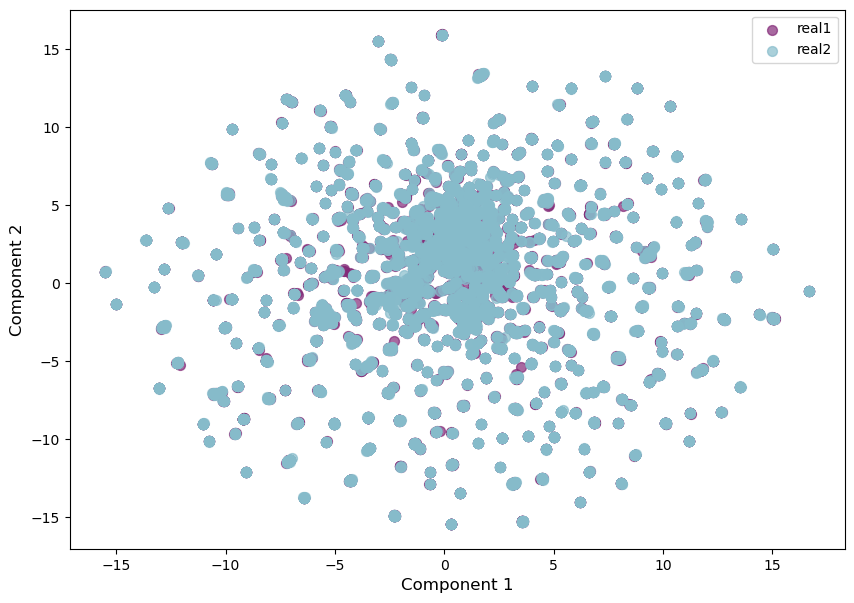

In [13]:
geno_UMAP(cows_1,cows_2,"real1","real2",path_cows_all+"umap.png")

## Precision and Recall 

### Using L2 distance

In [18]:
precision_cows_all_euc, recall_cows_all_euc = get_precision_recall(torch.tensor(cows_1.to_numpy()).to(dtype=torch.float32), torch.tensor(cows_2.to_numpy()).to(dtype=torch.float32), ks=ks, distance = "euclidean")

Evaluated k-NN precision and recall in: 26.0333s


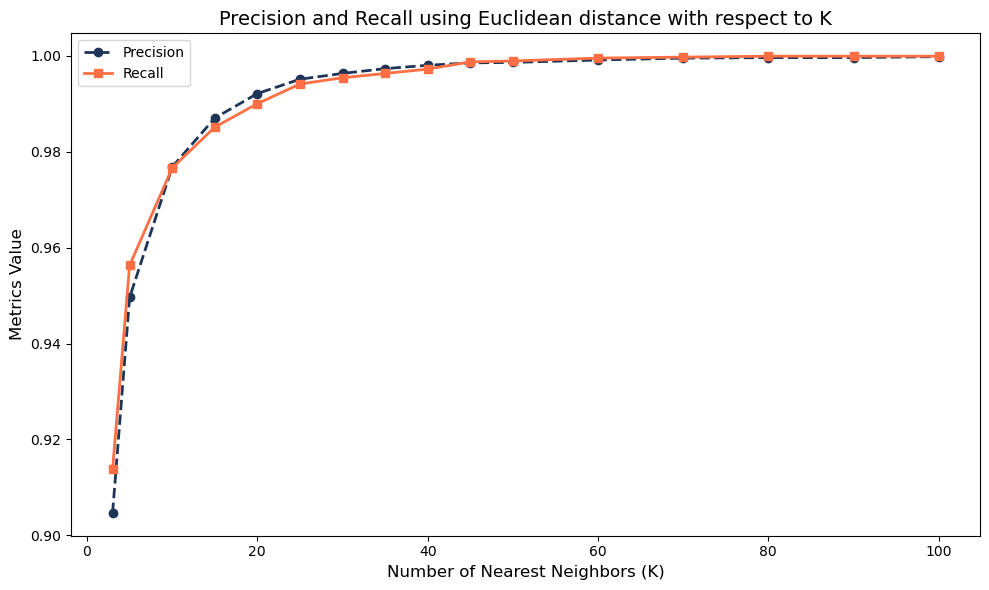

In [27]:
# Plot precision and recall on the same graph
plt.figure(figsize=(10, 6))
plt.plot(ks, precision_cows_all_euc, marker='o', label='Precision', color='#1D3557', linestyle='--', linewidth=2)
plt.plot(ks, recall_cows_all_euc, marker='s', label='Recall', color='#FF6F43', linestyle='-', linewidth=2)
plt.title("Precision and Recall using Euclidean distance with respect to K", fontsize=14)
plt.xlabel("Number of Nearest Neighbors (K)", fontsize=12)
plt.ylabel("Metrics Value", fontsize=12)
plt.legend(fontsize=10)
# Customize layout
plt.tight_layout()

# Save and show the plot
plt.savefig(path_cows_all+"precision_recall_euc.png", dpi=300)
plt.show()

In [19]:
precision_cows_all_euc

array([0.9047, 0.9496, 0.9768, 0.987 , 0.9921, 0.9951, 0.9963, 0.9973,
       0.998 , 0.9985, 0.9986, 0.9991, 0.9995, 0.9996, 0.9996, 0.9998])

In [20]:
recall_cows_all_euc

array([0.9138, 0.9563, 0.9766, 0.9851, 0.99  , 0.9941, 0.9954, 0.9963,
       0.9972, 0.9987, 0.9989, 0.9995, 0.9997, 0.9999, 0.9999, 0.9999])

### Using L1 distance

In [21]:
precision_cows_all_mht, recall_cows_all_mht = get_precision_recall(torch.tensor(cows_1.to_numpy()).to(dtype=torch.float32), torch.tensor(cows_2.to_numpy()).to(dtype=torch.float32), ks=ks, distance = "manhattan")

Evaluated k-NN precision and recall in: 349.311s


In [22]:
precision_cows_all_mht

array([0.9015, 0.95  , 0.9767, 0.9875, 0.9915, 0.9952, 0.9971, 0.9981,
       0.9986, 0.9987, 0.999 , 0.9993, 0.9995, 0.9998, 0.9998, 1.    ])

In [23]:
recall_cows_all_mht

array([0.9085, 0.9546, 0.9777, 0.9865, 0.9909, 0.9942, 0.9959, 0.9976,
       0.9982, 0.9987, 0.9991, 0.9994, 0.9996, 0.9998, 0.9998, 0.9999])

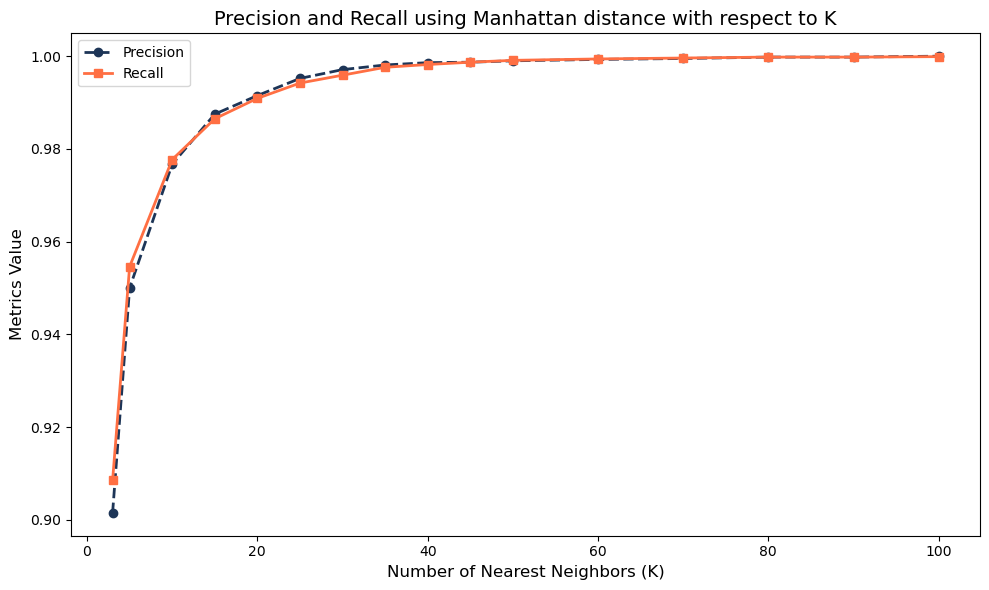

In [28]:
# Plot precision and recall on the same graph
plt.figure(figsize=(10, 6))
plt.plot(ks, precision_cows_all_mht, marker='o', label='Precision', color='#1D3557', linestyle='--', linewidth=2)
plt.plot(ks, recall_cows_all_mht, marker='s', label='Recall', color='#FF6F43', linestyle='-', linewidth=2)
plt.title("Precision and Recall using Manhattan distance with respect to K", fontsize=14)
plt.xlabel("Number of Nearest Neighbors (K)", fontsize=12)
plt.ylabel("Metrics Value", fontsize=12)
plt.legend(fontsize=10)
# Customize layout
plt.tight_layout()

# Save and show the plot
plt.savefig(path_cows_all+"precision_recall_mht.png", dpi=300)
plt.show()

## Correlation Score

In [39]:
corr_cows_all = corr_score(cows_1, cows_2)
print("Correlation Score between two real datasets from cow's all chromosomes: " + str(corr_cows_all))

Correlation Score between two real datasets from cow's all chromosomes: 0.9153436122782673


## Allele Frequency

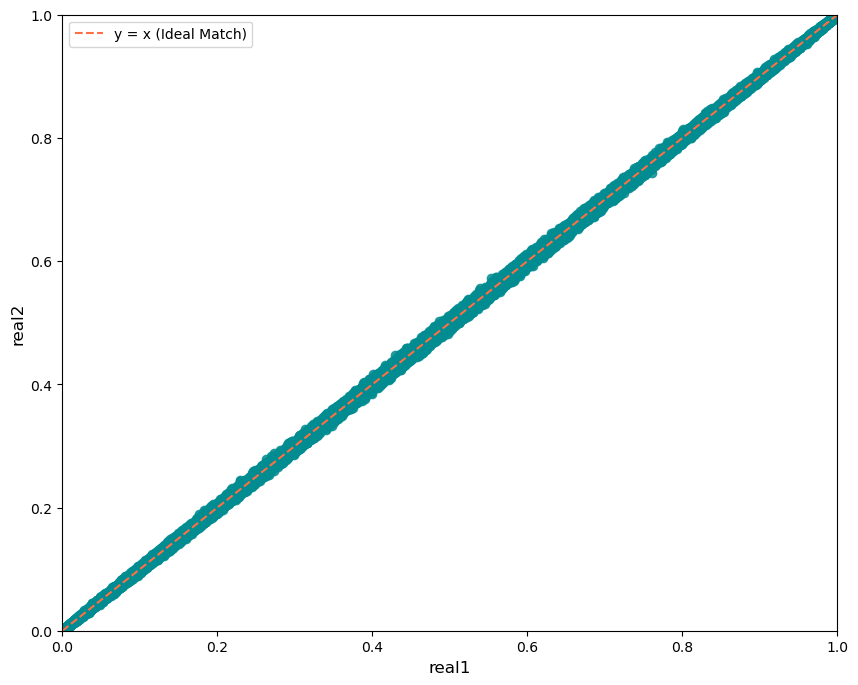

In [27]:
plot_allele_freq(allele_freq(cows_1), allele_freq(cows_2), "real1", "real2", path_cows_all+"allele_freq.png")

## Geno Frequency

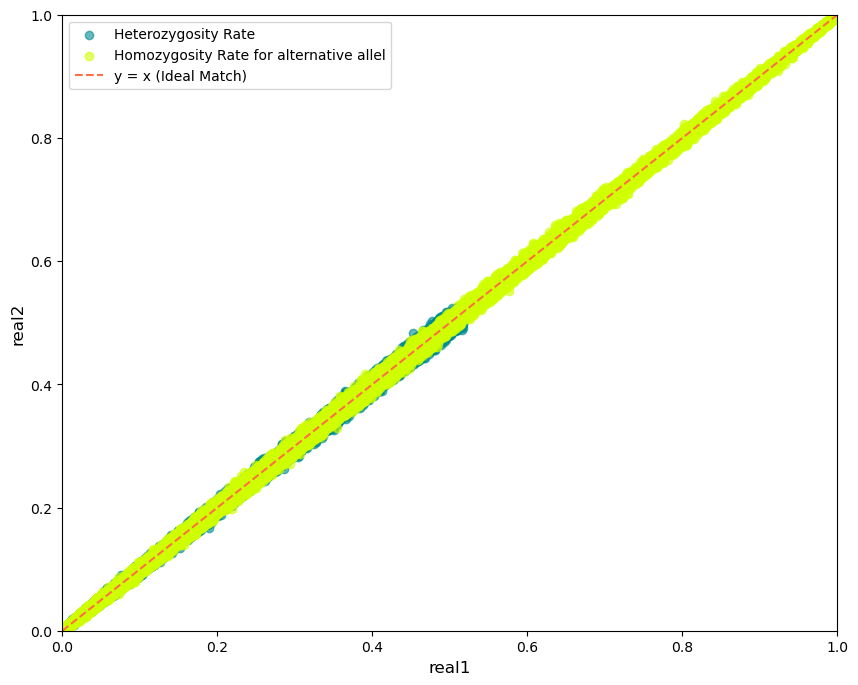

In [13]:
plot_geno_freq(cows_1, cows_2, "real1", "real2", path_cows_all+"geno_freq.png")

## LD

In [37]:
import allel
from scipy.spatial.distance import squareform

In [28]:
cows_ch1_1.values

array([[1, 1, 2, ..., 2, 1, 0],
       [1, 0, 2, ..., 2, 0, 0],
       [0, 0, 2, ..., 2, 2, 1],
       ...,
       [1, 0, 2, ..., 2, 0, 2],
       [0, 2, 2, ..., 1, 0, 1],
       [1, 0, 2, ..., 2, 1, 1]], dtype=uint8)

In [29]:
r = allel.rogers_huff_r(cows_ch1_1.values.T)

In [32]:
ld = r**2

In [62]:
co_matrix = cows_ch1_1.corr()

In [66]:
co_matrix.iloc[1208,1215]

-1.0

In [38]:
square_matrix = squareform(ld)

In [57]:
square_matrix[1160][1167]

1.0

In [40]:
for i in range(len(square_matrix)):
    for j in range(i+1, len(square_matrix)):
        if square_matrix[i][j] > 1 :
            print(i)
            print(j)
            break

804
805
1158
1159
1159
1160
1160
1161
1161
1167
1166
1167
1167
1169
1168
1169
1202
1203
1203
1205
1205
1215
1208
1215
1210
1215
1212
1215
1238
1239
1497
1499
1778
1780
1779
1780
1780
1782
2023
2024
2346
2347
2468
2469
2717
2718


In [53]:
cows_ch1_1.iloc[:, 1160]

46377    0
65707    0
67091    0
41544    0
66166    0
        ..
50544    0
3804     0
87277    0
6517     0
18997    0
Name: geno_SNP1216, Length: 10000, dtype: uint8

In [54]:
 cows_ch1_1.iloc[:, 1161]

46377    2
65707    2
67091    2
41544    2
66166    2
        ..
50544    2
3804     2
87277    2
6517     2
18997    2
Name: geno_SNP1217, Length: 10000, dtype: uint8

In [55]:
cows_ch1_1.iloc[:, 1167]

46377    0
65707    0
67091    0
41544    0
66166    0
        ..
50544    0
3804     0
87277    0
6517     0
18997    0
Name: geno_SNP1224, Length: 10000, dtype: uint8

In [52]:
sum(cows_ch1_1.iloc[:, 1160] == cows_ch1_1.iloc[:, 1161])

83

In [49]:
cows_ch1_1.iloc[:, 1161].value_counts()

geno_SNP1217
2    9916
1      83
0       1
Name: count, dtype: int64

In [50]:
cows_ch1_1.iloc[:, 1167].value_counts()

geno_SNP1224
0    9916
1      83
2       1
Name: count, dtype: int64

## AATS

### Using L2 distance

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


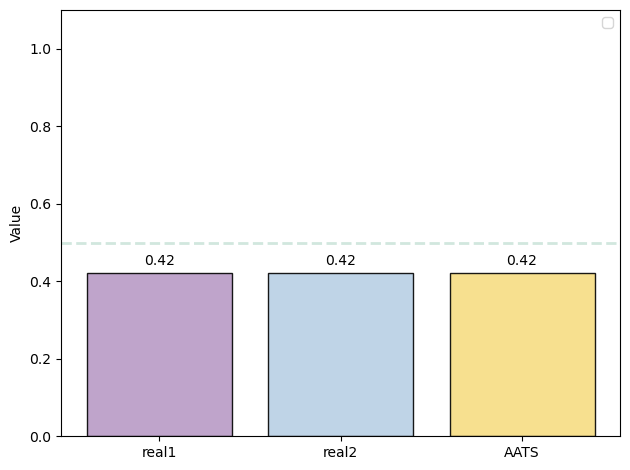

In [15]:
plot_aats(AATS(cows_1, cows_2, metric="euclidean"), "real1", "real2", path_cows_all+"AATS_euc.png")

### Using L1 distance

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


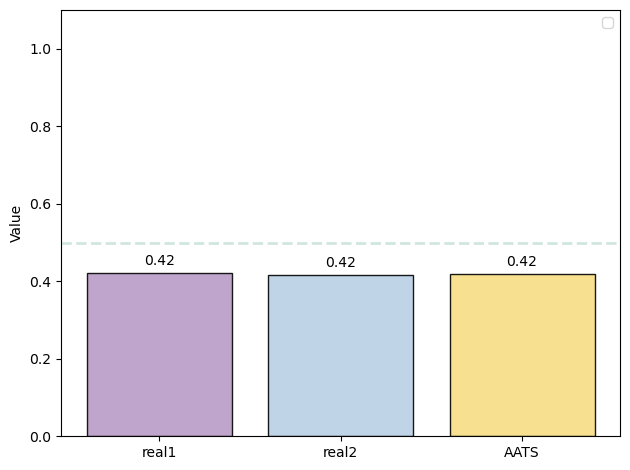

In [16]:
plot_aats(AATS(cows_1, cows_2, metric="manhattan"), "real1", "real2", path_cows_all+"AATS_mht.png")

# Real (training dataset) VS Randomly generated dataset

## Wasserstein Distance of the first 2000 PCs

In [18]:
pca_train = PCA(n_components=2000)
pca_random = PCA(n_components=2000)
pca_train_2000 = pca_train.fit_transform(sampled_RG_train)
pca_random_2000 = pca_random.fit_transform(snp_sequences)

# Cost matrix: Use Euclidean distance between all samples in the first 100 PC space
cost_matrix = ot.dist(pca_train_2000, pca_random_2000, metric='euclidean')

# Uniform weights for true and fake distributions (assuming equal importance)
weights_true = np.ones(20000) / 20000
weights_fake = np.ones(20000) / 20000

# Compute Wasserstein distance using POT
wasserstein_distance = ot.emd2(weights_true, weights_fake, cost_matrix)
print(f"Multi-Dimensional Wasserstein Distance: {wasserstein_distance}")

Multi-Dimensional Wasserstein Distance: 55.75315464245697


/opt/conda/lib/python3.11/site-packages/ot/lp/__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


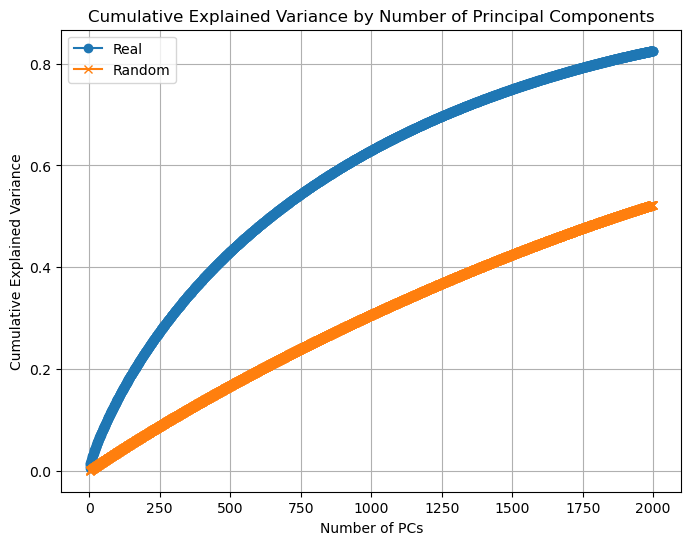

In [23]:
# Compute cumulative explained variance
cumu_var_train = np.cumsum(pca_train.explained_variance_ratio_)
cumu_var_random = np.cumsum(pca_random.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumu_var_train) + 1), cumu_var_train, marker='o', label='Real')
plt.plot(range(1, len(cumu_var_random) + 1), cumu_var_random, marker='x', label='Random')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.legend() 
plt.grid()
plt.show()

## PCA Visualization

In [33]:
# Convert to Pandas DataFrame
random = pd.DataFrame(random)
random.columns = sampled_RG_train.columns

In [34]:
# Use assign() to add the 'Origin' column simultaneously
combined_real_random = pd.concat([
    sampled_RG_train.assign(Origin='real'),
    random.assign(Origin='random')
], ignore_index=True)

In [35]:
pca = PCA(n_components=8)
snps_2d = pca.fit_transform(combined_real_random.drop(combined_real_random.columns[-1], axis=1))

In [36]:
real_snps_2d = snps_2d[:10000, :]
random_snps_2d = snps_2d[10000:, :]

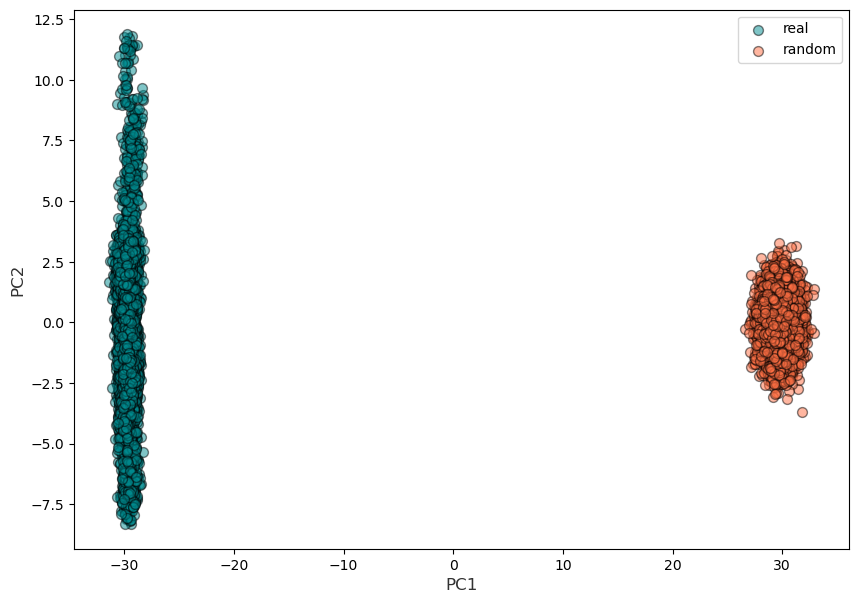

In [37]:
plt.figure(figsize=(10, 7))

# Plot real SNP sequences
plt.scatter(real_snps_2d[:, 0], real_snps_2d[:, 1], alpha=0.5, label='real', color="#008C90", edgecolor="k", s=50)
# Plot randomly generated SNP sequences
plt.scatter(random_snps_2d[:, 0], random_snps_2d[:, 1], alpha=0.5, label='random', color="#FF6F43", edgecolor="k", s=50)

plt.xlabel('PC1', fontsize=12, color="#323232")
plt.ylabel('PC2', fontsize=12, color="#323232")
plt.legend()
plt.savefig("pca_wgangp_count_ukb_ch15_real_vs_random.png")
plt.show()

## UMAP Visualization

In [16]:
reducer = umap.UMAP(random_state=42)
snp_umap = reducer.fit_transform(combined_real_random.drop(combined_real_random.columns[-1], axis=1))
real_umap = snp_umap[:10000, :]
random_umap = snp_umap[10000:, :]

/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/conda/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


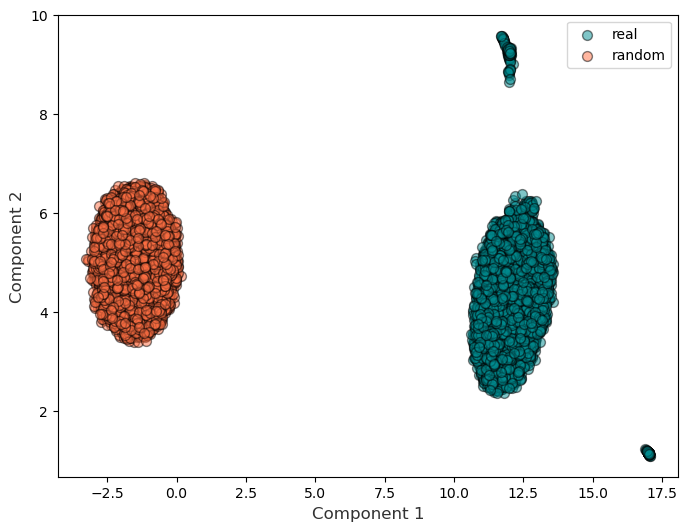

In [17]:
# Plot PCA results
plt.figure(figsize=(8, 6))
# Plot true SNP sequences
plt.scatter(real_umap[:, 0], real_umap[:, 1], alpha=0.5, label='real', color="#008C90", edgecolor="k", s=50)
# Plot generated SNP sequences
plt.scatter(random_umap[:, 0], random_umap[:, 1], alpha=0.5, label='random', color="#FF6F43", edgecolor="k", s=50)
#plt.title('UMAP for real and randomly generated dataset')
plt.xlabel('Component 1', fontsize=12, color="#323232")
plt.ylabel('Component 2', fontsize=12, color="#323232")
plt.legend()
plt.savefig("umap_wgangp_count_ukb_ch15_real_vs_random.png")
plt.show()

# Real VS Freq

## UMAP

In [18]:
freq.columns = sampled_RG_train.columns

In [20]:
combined_real_freq = pd.concat([
    sampled_RG_train.assign(Origin='real'),
    freq.assign(Origin='freq')
], ignore_index=True)

In [31]:
reducer = umap.UMAP(random_state=42)
snp_umap = reducer.fit_transform(combined_real_freq.drop(combined_real_freq.columns[-1], axis=1))
real_umap = snp_umap[:10000, :]
freq_umap = snp_umap[10000:, :]

/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


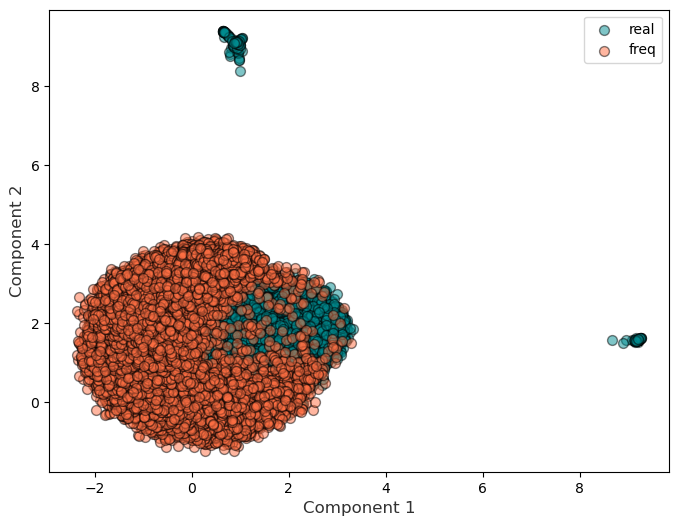

In [32]:
# Plot PCA results
plt.figure(figsize=(8, 6))
# Plot true SNP sequences
plt.scatter(real_umap[:, 0], real_umap[:, 1], alpha=0.5, label='real', color="#008C90", edgecolor="k", s=50)
# Plot generated SNP sequences
plt.scatter(freq_umap[:, 0], freq_umap[:, 1], alpha=0.5, label='freq', color="#FF6F43", edgecolor="k", s=50)
#plt.title('UMAP for real and randomly generated dataset')
plt.xlabel('Component 1', fontsize=12, color="#323232")
plt.ylabel('Component 2', fontsize=12, color="#323232")
plt.legend()
plt.savefig("umap_wgangp_count_ukb_ch15_real_vs_freq.png")
plt.show()

## PCA

In [27]:
pca = PCA(n_components=8)
snps_2d = pca.fit_transform(combined_real_freq.drop(combined_real_freq.columns[-1], axis=1))

In [28]:
real_snps_2d = snps_2d[:10000, :]
freq_snps_2d = snps_2d[10000:, :]

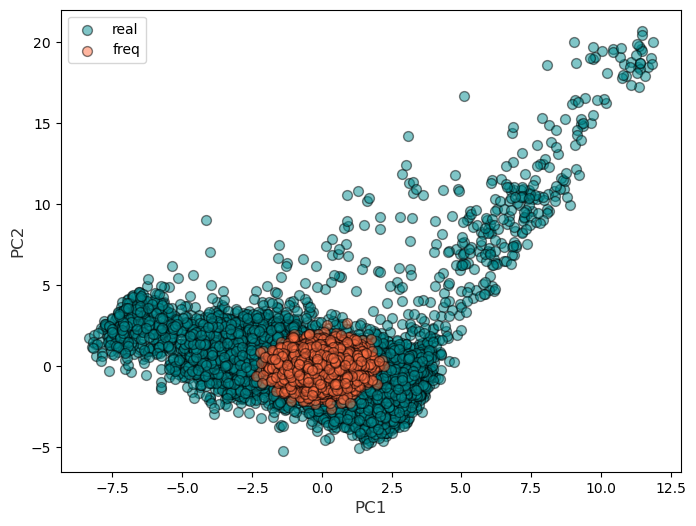

In [30]:
# Plot PCA results
plt.figure(figsize=(8, 6))
# Plot true SNP sequences
plt.scatter(real_snps_2d[:, 0], real_snps_2d[:, 1], alpha=0.5, label='real', color="#008C90", edgecolor="k", s=50)
# Plot generated SNP sequences
plt.scatter(freq_snps_2d[:, 0], freq_snps_2d[:, 1], alpha=0.5, label='freq', color="#FF6F43", edgecolor="k", s=50)
#plt.title('UMAP for real and randomly generated dataset')
plt.xlabel('PC1', fontsize=12, color="#323232")
plt.ylabel('PC2', fontsize=12, color="#323232")
plt.legend()
plt.savefig("pca_wgangp_count_ukb_ch15_real_vs_freq.png")
plt.show()

# Real VS Real

In [38]:
combined_real_real = pd.concat([
    sampled_RG_train.assign(Origin='real'),
    sampled_RG_val.assign(Origin='real')
], ignore_index=True)

In [39]:
pca = PCA(n_components=8)
snps_2d = pca.fit_transform(combined_real_real.drop(combined_real_real.columns[-1], axis=1))

In [40]:
train_snps_2d = snps_2d[:10000, :]
val_snps_2d = snps_2d[10000:, :]

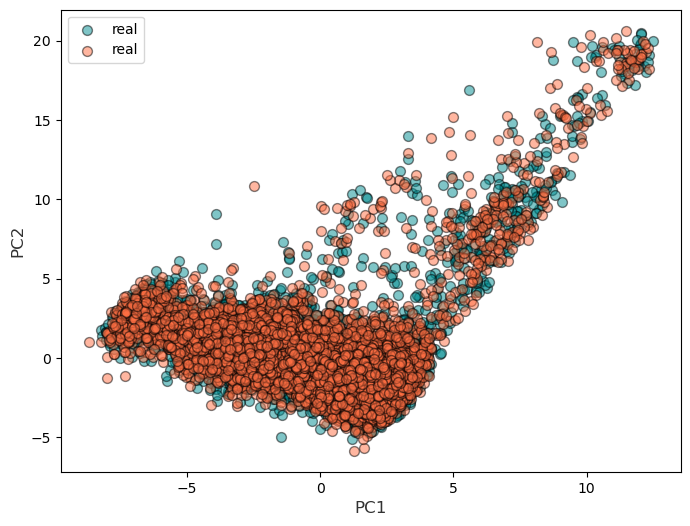

In [41]:
# Plot PCA results
plt.figure(figsize=(8, 6))
# Plot true SNP sequences
plt.scatter(train_snps_2d[:, 0], train_snps_2d[:, 1], alpha=0.5, label='real', color="#008C90", edgecolor="k", s=50)
# Plot generated SNP sequences
plt.scatter(val_snps_2d[:, 0], val_snps_2d[:, 1], alpha=0.5, label='real', color="#FF6F43", edgecolor="k", s=50)
#plt.title('UMAP for real and randomly generated dataset')
plt.xlabel('PC1', fontsize=12, color="#323232")
plt.ylabel('PC2', fontsize=12, color="#323232")
plt.legend()
plt.savefig("pca_wgangp_count_ukb_ch15_real_vs_real.png")
plt.show()